In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(226755, 828)
(226755, 1)
validation
(42717, 828)
(42717, 1)
test
(21245, 828)
(21245, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/23 [>.............................] - ETA: 27s - loss: 0.0517 - STD: 1.4652e-04 - MAE: 0.2082

 4/23 [====>.........................] - ETA: 0s - loss: 0.0268 - STD: 2.7701e-04 - MAE: 0.1277 

 5/23 [=====>........................] - ETA: 0s - loss: 0.0266 - STD: 2.6255e-04 - MAE: 0.1270

 6/23 [======>.......................] - ETA: 0s - loss: 0.0266 - STD: 2.4863e-04 - MAE: 0.1268

 7/23 [========>.....................] - ETA: 0s - loss: 0.0264 - STD: 2.3783e-04 - MAE: 0.1259

 8/23 [=========>....................] - ETA: 0s - loss: 0.0260 - STD: 2.3001e-04 - MAE: 0.1245

 9/23 [==========>...................] - ETA: 0s - loss: 0.0254 - STD: 2.2535e-04 - MAE: 0.1221

10/23 [============>.................] - ETA: 0s - loss: 0.0244 - STD: 2.2348e-04 - MAE: 0.1190

11/23 [=============>................] - ETA: 0s - loss: 0.0235 - STD: 2.2378e-04 - MAE: 0.1159

12/23 [==============>...............] - ETA: 0s - loss: 0.0226 - STD: 2.2560e-04 - MAE: 0.1132

13/23 [===============>..............] - ETA: 1s - loss: 0.0220 - STD: 2.2872e-04 - MAE: 0.1113

17/23 [=====================>........] - ETA: 0s - loss: 0.0204 - STD: 2.4772e-04 - MAE: 0.1099

18/23 [======================>.......] - ETA: 0s - loss: 0.0200 - STD: 2.5331e-04 - MAE: 0.1093

19/23 [=======================>......] - ETA: 0s - loss: 0.0197 - STD: 2.5885e-04 - MAE: 0.1085

20/23 [=========================>....] - ETA: 0s - loss: 0.0193 - STD: 2.6407e-04 - MAE: 0.1075

21/23 [==========================>...] - ETA: 0s - loss: 0.0189 - STD: 2.6883e-04 - MAE: 0.1064

22/23 [===========================>..] - ETA: 0s - loss: 0.0186 - STD: 2.7316e-04 - MAE: 0.1053

23/23 [==============================] - ETA: 0s - loss: 0.0184 - STD: 2.7707e-04 - MAE: 0.1044

23/23 [==============================] - 4s 111ms/step - loss: 0.0184 - STD: 2.7707e-04 - MAE: 0.1044 - val_loss: 0.0171 - val_STD: 3.2625e-04 - val_MAE: 0.0951


Epoch 2/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0133 - STD: 3.6706e-04 - MAE: 0.0836

 2/23 [=>............................] - ETA: 1s - loss: 0.0132 - STD: 3.7248e-04 - MAE: 0.0832

 3/23 [==>...........................] - ETA: 1s - loss: 0.0133 - STD: 3.7750e-04 - MAE: 0.0833

 4/23 [====>.........................] - ETA: 1s - loss: 0.0133 - STD: 3.8469e-04 - MAE: 0.0834

 5/23 [=====>........................] - ETA: 1s - loss: 0.0132 - STD: 3.9358e-04 - MAE: 0.0833

 6/23 [======>.......................] - ETA: 1s - loss: 0.0131 - STD: 4.0311e-04 - MAE: 0.0833

 7/23 [========>.....................] - ETA: 1s - loss: 0.0130 - STD: 4.1425e-04 - MAE: 0.0834

 8/23 [=========>....................] - ETA: 1s - loss: 0.0128 - STD: 4.2658e-04 - MAE: 0.0835

 9/23 [==========>...................] - ETA: 0s - loss: 0.0127 - STD: 4.3879e-04 - MAE: 0.0838

10/23 [============>.................] - ETA: 0s - loss: 0.0127 - STD: 4.5137e-04 - MAE: 0.0842

11/23 [=============>................] - ETA: 0s - loss: 0.0126 - STD: 4.6455e-04 - MAE: 0.0847

12/23 [==============>...............] - ETA: 0s - loss: 0.0126 - STD: 4.7695e-04 - MAE: 0.0852

14/23 [=================>............] - ETA: 0s - loss: 0.0126 - STD: 5.0104e-04 - MAE: 0.0860

15/23 [==================>...........] - ETA: 0s - loss: 0.0126 - STD: 5.1262e-04 - MAE: 0.0862

16/23 [===================>..........] - ETA: 0s - loss: 0.0126 - STD: 5.2321e-04 - MAE: 0.0863

17/23 [=====================>........] - ETA: 0s - loss: 0.0125 - STD: 5.3323e-04 - MAE: 0.0863

18/23 [======================>.......] - ETA: 0s - loss: 0.0125 - STD: 5.4311e-04 - MAE: 0.0862

19/23 [=======================>......] - ETA: 0s - loss: 0.0125 - STD: 5.5239e-04 - MAE: 0.0861

20/23 [=========================>....] - ETA: 0s - loss: 0.0124 - STD: 5.6168e-04 - MAE: 0.0860

21/23 [==========================>...] - ETA: 0s - loss: 0.0124 - STD: 5.7130e-04 - MAE: 0.0858

22/23 [===========================>..] - ETA: 0s - loss: 0.0124 - STD: 5.8097e-04 - MAE: 0.0857

23/23 [==============================] - ETA: 0s - loss: 0.0124 - STD: 5.9132e-04 - MAE: 0.0856

23/23 [==============================] - 2s 73ms/step - loss: 0.0124 - STD: 5.9132e-04 - MAE: 0.0856 - val_loss: 0.0149 - val_STD: 7.5553e-04 - val_MAE: 0.0923


Epoch 3/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0120 - STD: 8.6027e-04 - MAE: 0.0831

 2/23 [=>............................] - ETA: 1s - loss: 0.0120 - STD: 8.8185e-04 - MAE: 0.0837

 3/23 [==>...........................] - ETA: 1s - loss: 0.0120 - STD: 9.0168e-04 - MAE: 0.0841

 4/23 [====>.........................] - ETA: 1s - loss: 0.0121 - STD: 9.2155e-04 - MAE: 0.0844

 5/23 [=====>........................] - ETA: 1s - loss: 0.0121 - STD: 9.4712e-04 - MAE: 0.0848

 6/23 [======>.......................] - ETA: 1s - loss: 0.0120 - STD: 9.7282e-04 - MAE: 0.0850

 7/23 [========>.....................] - ETA: 1s - loss: 0.0121 - STD: 9.9667e-04 - MAE: 0.0854

 8/23 [=========>....................] - ETA: 1s - loss: 0.0121 - STD: 0.0010 - MAE: 0.0855    

 9/23 [==========>...................] - ETA: 0s - loss: 0.0120 - STD: 0.0010 - MAE: 0.0856

10/23 [============>.................] - ETA: 0s - loss: 0.0120 - STD: 0.0011 - MAE: 0.0857

11/23 [=============>................] - ETA: 0s - loss: 0.0120 - STD: 0.0011 - MAE: 0.0858

12/23 [==============>...............] - ETA: 0s - loss: 0.0120 - STD: 0.0011 - MAE: 0.0857

13/23 [===============>..............] - ETA: 0s - loss: 0.0120 - STD: 0.0011 - MAE: 0.0857

14/23 [=================>............] - ETA: 0s - loss: 0.0120 - STD: 0.0012 - MAE: 0.0856

15/23 [==================>...........] - ETA: 0s - loss: 0.0120 - STD: 0.0012 - MAE: 0.0855

16/23 [===================>..........] - ETA: 0s - loss: 0.0120 - STD: 0.0012 - MAE: 0.0854

17/23 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 0.0012 - MAE: 0.0853

18/23 [======================>.......] - ETA: 0s - loss: 0.0120 - STD: 0.0013 - MAE: 0.0852

19/23 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 0.0013 - MAE: 0.0852

20/23 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 0.0013 - MAE: 0.0851

21/23 [==========================>...] - ETA: 0s - loss: 0.0120 - STD: 0.0014 - MAE: 0.0850

23/23 [==============================] - ETA: 0s - loss: 0.0119 - STD: 0.0014 - MAE: 0.0850

23/23 [==============================] - 2s 74ms/step - loss: 0.0119 - STD: 0.0014 - MAE: 0.0850 - val_loss: 0.0140 - val_STD: 0.0021 - val_MAE: 0.0924


Epoch 4/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0115 - STD: 0.0024 - MAE: 0.0842

 2/23 [=>............................] - ETA: 1s - loss: 0.0117 - STD: 0.0025 - MAE: 0.0851

 3/23 [==>...........................] - ETA: 1s - loss: 0.0116 - STD: 0.0025 - MAE: 0.0849

 4/23 [====>.........................] - ETA: 1s - loss: 0.0117 - STD: 0.0026 - MAE: 0.0850

 5/23 [=====>........................] - ETA: 1s - loss: 0.0117 - STD: 0.0027 - MAE: 0.0849

 6/23 [======>.......................] - ETA: 1s - loss: 0.0117 - STD: 0.0027 - MAE: 0.0849

 8/23 [=========>....................] - ETA: 0s - loss: 0.0117 - STD: 0.0029 - MAE: 0.0847

 9/23 [==========>...................] - ETA: 0s - loss: 0.0117 - STD: 0.0030 - MAE: 0.0846

10/23 [============>.................] - ETA: 0s - loss: 0.0117 - STD: 0.0031 - MAE: 0.0844

11/23 [=============>................] - ETA: 0s - loss: 0.0117 - STD: 0.0032 - MAE: 0.0843

12/23 [==============>...............] - ETA: 0s - loss: 0.0117 - STD: 0.0032 - MAE: 0.0843

13/23 [===============>..............] - ETA: 0s - loss: 0.0116 - STD: 0.0034 - MAE: 0.0842

14/23 [=================>............] - ETA: 0s - loss: 0.0116 - STD: 0.0035 - MAE: 0.0842

15/23 [==================>...........] - ETA: 0s - loss: 0.0116 - STD: 0.0036 - MAE: 0.0842

16/23 [===================>..........] - ETA: 0s - loss: 0.0116 - STD: 0.0037 - MAE: 0.0842

17/23 [=====================>........] - ETA: 0s - loss: 0.0116 - STD: 0.0038 - MAE: 0.0841

18/23 [======================>.......] - ETA: 0s - loss: 0.0116 - STD: 0.0040 - MAE: 0.0842

19/23 [=======================>......] - ETA: 0s - loss: 0.0116 - STD: 0.0041 - MAE: 0.0841

20/23 [=========================>....] - ETA: 0s - loss: 0.0116 - STD: 0.0043 - MAE: 0.0841

21/23 [==========================>...] - ETA: 0s - loss: 0.0116 - STD: 0.0044 - MAE: 0.0841

22/23 [===========================>..] - ETA: 0s - loss: 0.0116 - STD: 0.0046 - MAE: 0.0840

23/23 [==============================] - ETA: 0s - loss: 0.0116 - STD: 0.0048 - MAE: 0.0841

23/23 [==============================] - 2s 71ms/step - loss: 0.0116 - STD: 0.0048 - MAE: 0.0841 - val_loss: 0.0135 - val_STD: 0.0083 - val_MAE: 0.0901


Epoch 5/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0110 - STD: 0.0095 - MAE: 0.0823

 2/23 [=>............................] - ETA: 1s - loss: 0.0110 - STD: 0.0098 - MAE: 0.0822

 3/23 [==>...........................] - ETA: 1s - loss: 0.0111 - STD: 0.0102 - MAE: 0.0822

 4/23 [====>.........................] - ETA: 1s - loss: 0.0110 - STD: 0.0106 - MAE: 0.0822

 5/23 [=====>........................] - ETA: 1s - loss: 0.0110 - STD: 0.0110 - MAE: 0.0820

 6/23 [======>.......................] - ETA: 1s - loss: 0.0110 - STD: 0.0114 - MAE: 0.0820

 7/23 [========>.....................] - ETA: 1s - loss: 0.0110 - STD: 0.0119 - MAE: 0.0820

 8/23 [=========>....................] - ETA: 1s - loss: 0.0110 - STD: 0.0124 - MAE: 0.0820

 9/23 [==========>...................] - ETA: 0s - loss: 0.0110 - STD: 0.0129 - MAE: 0.0820

10/23 [============>.................] - ETA: 0s - loss: 0.0109 - STD: 0.0134 - MAE: 0.0820

11/23 [=============>................] - ETA: 0s - loss: 0.0109 - STD: 0.0140 - MAE: 0.0819

12/23 [==============>...............] - ETA: 0s - loss: 0.0109 - STD: 0.0145 - MAE: 0.0817

13/23 [===============>..............] - ETA: 0s - loss: 0.0108 - STD: 0.0151 - MAE: 0.0816

14/23 [=================>............] - ETA: 0s - loss: 0.0108 - STD: 0.0157 - MAE: 0.0814

16/23 [===================>..........] - ETA: 0s - loss: 0.0107 - STD: 0.0170 - MAE: 0.0811

17/23 [=====================>........] - ETA: 0s - loss: 0.0107 - STD: 0.0177 - MAE: 0.0810

18/23 [======================>.......] - ETA: 0s - loss: 0.0106 - STD: 0.0184 - MAE: 0.0808

19/23 [=======================>......] - ETA: 0s - loss: 0.0106 - STD: 0.0192 - MAE: 0.0807

20/23 [=========================>....] - ETA: 0s - loss: 0.0106 - STD: 0.0199 - MAE: 0.0806

21/23 [==========================>...] - ETA: 0s - loss: 0.0105 - STD: 0.0207 - MAE: 0.0804

22/23 [===========================>..] - ETA: 0s - loss: 0.0105 - STD: 0.0214 - MAE: 0.0803

23/23 [==============================] - ETA: 0s - loss: 0.0104 - STD: 0.0222 - MAE: 0.0802

23/23 [==============================] - 2s 73ms/step - loss: 0.0104 - STD: 0.0222 - MAE: 0.0802 - val_loss: 0.0120 - val_STD: 0.0352 - val_MAE: 0.0847


Epoch 6/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0096 - STD: 0.0402 - MAE: 0.0767

 2/23 [=>............................] - ETA: 1s - loss: 0.0097 - STD: 0.0407 - MAE: 0.0769

 3/23 [==>...........................] - ETA: 1s - loss: 0.0097 - STD: 0.0413 - MAE: 0.0768

 4/23 [====>.........................] - ETA: 1s - loss: 0.0097 - STD: 0.0419 - MAE: 0.0766

 5/23 [=====>........................] - ETA: 1s - loss: 0.0097 - STD: 0.0425 - MAE: 0.0767

 6/23 [======>.......................] - ETA: 1s - loss: 0.0097 - STD: 0.0431 - MAE: 0.0768

 7/23 [========>.....................] - ETA: 1s - loss: 0.0096 - STD: 0.0436 - MAE: 0.0767

 8/23 [=========>....................] - ETA: 1s - loss: 0.0096 - STD: 0.0441 - MAE: 0.0765

 9/23 [==========>...................] - ETA: 0s - loss: 0.0095 - STD: 0.0445 - MAE: 0.0764

10/23 [============>.................] - ETA: 0s - loss: 0.0096 - STD: 0.0448 - MAE: 0.0764

11/23 [=============>................] - ETA: 0s - loss: 0.0096 - STD: 0.0450 - MAE: 0.0762

12/23 [==============>...............] - ETA: 0s - loss: 0.0095 - STD: 0.0452 - MAE: 0.0761

13/23 [===============>..............] - ETA: 0s - loss: 0.0095 - STD: 0.0454 - MAE: 0.0760

14/23 [=================>............] - ETA: 0s - loss: 0.0095 - STD: 0.0455 - MAE: 0.0759

15/23 [==================>...........] - ETA: 0s - loss: 0.0095 - STD: 0.0456 - MAE: 0.0758

16/23 [===================>..........] - ETA: 0s - loss: 0.0095 - STD: 0.0457 - MAE: 0.0758

17/23 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 0.0458 - MAE: 0.0757

18/23 [======================>.......] - ETA: 0s - loss: 0.0094 - STD: 0.0458 - MAE: 0.0756

20/23 [=========================>....] - ETA: 0s - loss: 0.0094 - STD: 0.0458 - MAE: 0.0753

21/23 [==========================>...] - ETA: 0s - loss: 0.0094 - STD: 0.0459 - MAE: 0.0752

22/23 [===========================>..] - ETA: 0s - loss: 0.0094 - STD: 0.0460 - MAE: 0.0751

23/23 [==============================] - ETA: 0s - loss: 0.0093 - STD: 0.0460 - MAE: 0.0751

23/23 [==============================] - 2s 73ms/step - loss: 0.0093 - STD: 0.0460 - MAE: 0.0751 - val_loss: 0.0111 - val_STD: 0.0422 - val_MAE: 0.0813


Epoch 7/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0091 - STD: 0.0484 - MAE: 0.0739

 2/23 [=>............................] - ETA: 1s - loss: 0.0090 - STD: 0.0486 - MAE: 0.0739

 3/23 [==>...........................] - ETA: 1s - loss: 0.0089 - STD: 0.0487 - MAE: 0.0734

 4/23 [====>.........................] - ETA: 1s - loss: 0.0089 - STD: 0.0490 - MAE: 0.0729

 5/23 [=====>........................] - ETA: 1s - loss: 0.0089 - STD: 0.0491 - MAE: 0.0728

 6/23 [======>.......................] - ETA: 1s - loss: 0.0089 - STD: 0.0493 - MAE: 0.0727

 7/23 [========>.....................] - ETA: 1s - loss: 0.0088 - STD: 0.0496 - MAE: 0.0726

 8/23 [=========>....................] - ETA: 1s - loss: 0.0088 - STD: 0.0499 - MAE: 0.0725

 9/23 [==========>...................] - ETA: 0s - loss: 0.0088 - STD: 0.0501 - MAE: 0.0725

10/23 [============>.................] - ETA: 0s - loss: 0.0088 - STD: 0.0502 - MAE: 0.0724

11/23 [=============>................] - ETA: 0s - loss: 0.0088 - STD: 0.0504 - MAE: 0.0724

12/23 [==============>...............] - ETA: 0s - loss: 0.0088 - STD: 0.0506 - MAE: 0.0723

13/23 [===============>..............] - ETA: 0s - loss: 0.0087 - STD: 0.0508 - MAE: 0.0722

14/23 [=================>............] - ETA: 0s - loss: 0.0087 - STD: 0.0510 - MAE: 0.0722

15/23 [==================>...........] - ETA: 0s - loss: 0.0087 - STD: 0.0511 - MAE: 0.0721

16/23 [===================>..........] - ETA: 0s - loss: 0.0087 - STD: 0.0512 - MAE: 0.0720

17/23 [=====================>........] - ETA: 0s - loss: 0.0087 - STD: 0.0513 - MAE: 0.0718

18/23 [======================>.......] - ETA: 0s - loss: 0.0087 - STD: 0.0514 - MAE: 0.0717

19/23 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 0.0514 - MAE: 0.0716

20/23 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 0.0515 - MAE: 0.0715

21/23 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 0.0517 - MAE: 0.0715

23/23 [==============================] - ETA: 0s - loss: 0.0086 - STD: 0.0519 - MAE: 0.0713

23/23 [==============================] - 2s 74ms/step - loss: 0.0086 - STD: 0.0519 - MAE: 0.0713 - val_loss: 0.0096 - val_STD: 0.0501 - val_MAE: 0.0749


Epoch 8/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0081 - STD: 0.0553 - MAE: 0.0687

 2/23 [=>............................] - ETA: 1s - loss: 0.0079 - STD: 0.0555 - MAE: 0.0678

 3/23 [==>...........................] - ETA: 1s - loss: 0.0079 - STD: 0.0560 - MAE: 0.0680

 4/23 [====>.........................] - ETA: 1s - loss: 0.0079 - STD: 0.0566 - MAE: 0.0680

 5/23 [=====>........................] - ETA: 1s - loss: 0.0078 - STD: 0.0571 - MAE: 0.0679

 6/23 [======>.......................] - ETA: 1s - loss: 0.0078 - STD: 0.0575 - MAE: 0.0678

 7/23 [========>.....................] - ETA: 1s - loss: 0.0078 - STD: 0.0580 - MAE: 0.0676

 8/23 [=========>....................] - ETA: 1s - loss: 0.0077 - STD: 0.0583 - MAE: 0.0675

 9/23 [==========>...................] - ETA: 0s - loss: 0.0078 - STD: 0.0588 - MAE: 0.0675

10/23 [============>.................] - ETA: 0s - loss: 0.0077 - STD: 0.0594 - MAE: 0.0674

11/23 [=============>................] - ETA: 0s - loss: 0.0077 - STD: 0.0598 - MAE: 0.0673

12/23 [==============>...............] - ETA: 0s - loss: 0.0077 - STD: 0.0601 - MAE: 0.0672

13/23 [===============>..............] - ETA: 0s - loss: 0.0077 - STD: 0.0606 - MAE: 0.0671

14/23 [=================>............] - ETA: 0s - loss: 0.0077 - STD: 0.0610 - MAE: 0.0669

15/23 [==================>...........] - ETA: 0s - loss: 0.0077 - STD: 0.0612 - MAE: 0.0668

16/23 [===================>..........] - ETA: 0s - loss: 0.0076 - STD: 0.0616 - MAE: 0.0668

17/23 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.0619 - MAE: 0.0666

18/23 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.0620 - MAE: 0.0665

20/23 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.0627 - MAE: 0.0664

21/23 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.0628 - MAE: 0.0663

22/23 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.0630 - MAE: 0.0663

23/23 [==============================] - ETA: 0s - loss: 0.0075 - STD: 0.0630 - MAE: 0.0662

23/23 [==============================] - 2s 72ms/step - loss: 0.0075 - STD: 0.0630 - MAE: 0.0662 - val_loss: 0.0085 - val_STD: 0.0619 - val_MAE: 0.0696


Epoch 9/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0071 - STD: 0.0648 - MAE: 0.0635

 2/23 [=>............................] - ETA: 1s - loss: 0.0072 - STD: 0.0668 - MAE: 0.0647

 3/23 [==>...........................] - ETA: 1s - loss: 0.0072 - STD: 0.0658 - MAE: 0.0645

 4/23 [====>.........................] - ETA: 1s - loss: 0.0073 - STD: 0.0659 - MAE: 0.0645

 5/23 [=====>........................] - ETA: 1s - loss: 0.0072 - STD: 0.0663 - MAE: 0.0646

 6/23 [======>.......................] - ETA: 1s - loss: 0.0072 - STD: 0.0660 - MAE: 0.0643

 7/23 [========>.....................] - ETA: 1s - loss: 0.0072 - STD: 0.0662 - MAE: 0.0645

 8/23 [=========>....................] - ETA: 0s - loss: 0.0072 - STD: 0.0665 - MAE: 0.0644

 9/23 [==========>...................] - ETA: 0s - loss: 0.0072 - STD: 0.0663 - MAE: 0.0642

10/23 [============>.................] - ETA: 0s - loss: 0.0072 - STD: 0.0666 - MAE: 0.0641

11/23 [=============>................] - ETA: 0s - loss: 0.0071 - STD: 0.0668 - MAE: 0.0641

12/23 [==============>...............] - ETA: 0s - loss: 0.0071 - STD: 0.0666 - MAE: 0.0639

13/23 [===============>..............] - ETA: 0s - loss: 0.0071 - STD: 0.0668 - MAE: 0.0639

15/23 [==================>...........] - ETA: 0s - loss: 0.0071 - STD: 0.0667 - MAE: 0.0637

16/23 [===================>..........] - ETA: 0s - loss: 0.0071 - STD: 0.0670 - MAE: 0.0637

17/23 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0670 - MAE: 0.0636

18/23 [======================>.......] - ETA: 0s - loss: 0.0071 - STD: 0.0668 - MAE: 0.0635

19/23 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0670 - MAE: 0.0635

20/23 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0672 - MAE: 0.0635

21/23 [==========================>...] - ETA: 0s - loss: 0.0071 - STD: 0.0671 - MAE: 0.0634

22/23 [===========================>..] - ETA: 0s - loss: 0.0070 - STD: 0.0672 - MAE: 0.0634

23/23 [==============================] - ETA: 0s - loss: 0.0070 - STD: 0.0673 - MAE: 0.0633

23/23 [==============================] - 2s 71ms/step - loss: 0.0070 - STD: 0.0673 - MAE: 0.0633 - val_loss: 0.0081 - val_STD: 0.0658 - val_MAE: 0.0668


Epoch 10/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0067 - STD: 0.0676 - MAE: 0.0614

 2/23 [=>............................] - ETA: 1s - loss: 0.0067 - STD: 0.0687 - MAE: 0.0618

 3/23 [==>...........................] - ETA: 1s - loss: 0.0068 - STD: 0.0694 - MAE: 0.0622

 4/23 [====>.........................] - ETA: 1s - loss: 0.0068 - STD: 0.0690 - MAE: 0.0621

 5/23 [=====>........................] - ETA: 1s - loss: 0.0068 - STD: 0.0695 - MAE: 0.0621

 6/23 [======>.......................] - ETA: 1s - loss: 0.0068 - STD: 0.0697 - MAE: 0.0621

 7/23 [========>.....................] - ETA: 1s - loss: 0.0068 - STD: 0.0696 - MAE: 0.0618

 8/23 [=========>....................] - ETA: 0s - loss: 0.0068 - STD: 0.0696 - MAE: 0.0618

 9/23 [==========>...................] - ETA: 0s - loss: 0.0068 - STD: 0.0696 - MAE: 0.0618

10/23 [============>.................] - ETA: 0s - loss: 0.0067 - STD: 0.0697 - MAE: 0.0617

11/23 [=============>................] - ETA: 0s - loss: 0.0068 - STD: 0.0697 - MAE: 0.0617

12/23 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0698 - MAE: 0.0618

13/23 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.0696 - MAE: 0.0616

14/23 [=================>............] - ETA: 0s - loss: 0.0067 - STD: 0.0696 - MAE: 0.0616

15/23 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0697 - MAE: 0.0616

16/23 [===================>..........] - ETA: 0s - loss: 0.0067 - STD: 0.0696 - MAE: 0.0615

17/23 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0697 - MAE: 0.0614

18/23 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0699 - MAE: 0.0614

19/23 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0698 - MAE: 0.0613

20/23 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0701 - MAE: 0.0614

21/23 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0701 - MAE: 0.0612

22/23 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0699 - MAE: 0.0612

23/23 [==============================] - 2s 70ms/step - loss: 0.0067 - STD: 0.0702 - MAE: 0.0614 - val_loss: 0.0084 - val_STD: 0.0657 - val_MAE: 0.0665


Epoch 11/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0070 - STD: 0.0649 - MAE: 0.0599

 2/23 [=>............................] - ETA: 1s - loss: 0.0068 - STD: 0.0678 - MAE: 0.0597

 3/23 [==>...........................] - ETA: 1s - loss: 0.0070 - STD: 0.0714 - MAE: 0.0622

 4/23 [====>.........................] - ETA: 1s - loss: 0.0070 - STD: 0.0692 - MAE: 0.0618

 5/23 [=====>........................] - ETA: 1s - loss: 0.0069 - STD: 0.0689 - MAE: 0.0613

 7/23 [========>.....................] - ETA: 1s - loss: 0.0069 - STD: 0.0695 - MAE: 0.0620

 8/23 [=========>....................] - ETA: 0s - loss: 0.0069 - STD: 0.0687 - MAE: 0.0617

 9/23 [==========>...................] - ETA: 0s - loss: 0.0070 - STD: 0.0694 - MAE: 0.0622

10/23 [============>.................] - ETA: 0s - loss: 0.0069 - STD: 0.0696 - MAE: 0.0621

11/23 [=============>................] - ETA: 0s - loss: 0.0069 - STD: 0.0689 - MAE: 0.0620

12/23 [==============>...............] - ETA: 0s - loss: 0.0069 - STD: 0.0687 - MAE: 0.0617

13/23 [===============>..............] - ETA: 0s - loss: 0.0069 - STD: 0.0692 - MAE: 0.0621

14/23 [=================>............] - ETA: 0s - loss: 0.0069 - STD: 0.0692 - MAE: 0.0619

15/23 [==================>...........] - ETA: 0s - loss: 0.0069 - STD: 0.0689 - MAE: 0.0617

16/23 [===================>..........] - ETA: 0s - loss: 0.0068 - STD: 0.0689 - MAE: 0.0616

17/23 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.0692 - MAE: 0.0618

18/23 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0692 - MAE: 0.0616

19/23 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.0691 - MAE: 0.0615

20/23 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0693 - MAE: 0.0614

21/23 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0696 - MAE: 0.0614

22/23 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0695 - MAE: 0.0613

23/23 [==============================] - ETA: 0s - loss: 0.0067 - STD: 0.0695 - MAE: 0.0612

23/23 [==============================] - 2s 73ms/step - loss: 0.0067 - STD: 0.0695 - MAE: 0.0612 - val_loss: 0.0075 - val_STD: 0.0746 - val_MAE: 0.0648


Epoch 12/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0066 - STD: 0.0744 - MAE: 0.0620

 2/23 [=>............................] - ETA: 1s - loss: 0.0064 - STD: 0.0746 - MAE: 0.0612

 3/23 [==>...........................] - ETA: 1s - loss: 0.0064 - STD: 0.0724 - MAE: 0.0604

 4/23 [====>.........................] - ETA: 1s - loss: 0.0063 - STD: 0.0721 - MAE: 0.0597

 5/23 [=====>........................] - ETA: 1s - loss: 0.0063 - STD: 0.0726 - MAE: 0.0599

 6/23 [======>.......................] - ETA: 1s - loss: 0.0063 - STD: 0.0726 - MAE: 0.0597

 7/23 [========>.....................] - ETA: 1s - loss: 0.0063 - STD: 0.0721 - MAE: 0.0594

 8/23 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0723 - MAE: 0.0594

 9/23 [==========>...................] - ETA: 0s - loss: 0.0063 - STD: 0.0725 - MAE: 0.0595

10/23 [============>.................] - ETA: 0s - loss: 0.0063 - STD: 0.0724 - MAE: 0.0594

11/23 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0722 - MAE: 0.0593

12/23 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0723 - MAE: 0.0593

13/23 [===============>..............] - ETA: 0s - loss: 0.0063 - STD: 0.0724 - MAE: 0.0594

14/23 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0723 - MAE: 0.0593

15/23 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0724 - MAE: 0.0592

16/23 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0726 - MAE: 0.0593

17/23 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0727 - MAE: 0.0593

18/23 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0727 - MAE: 0.0592

19/23 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0728 - MAE: 0.0593

20/23 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0730 - MAE: 0.0593

22/23 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0730 - MAE: 0.0592

23/23 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0731 - MAE: 0.0593

23/23 [==============================] - 2s 72ms/step - loss: 0.0063 - STD: 0.0731 - MAE: 0.0593 - val_loss: 0.0074 - val_STD: 0.0739 - val_MAE: 0.0629


Epoch 13/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0727 - MAE: 0.0577

 2/23 [=>............................] - ETA: 1s - loss: 0.0061 - STD: 0.0721 - MAE: 0.0576

 3/23 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0735 - MAE: 0.0582

 4/23 [====>.........................] - ETA: 1s - loss: 0.0061 - STD: 0.0732 - MAE: 0.0580

 5/23 [=====>........................] - ETA: 1s - loss: 0.0062 - STD: 0.0729 - MAE: 0.0580

 7/23 [========>.....................] - ETA: 0s - loss: 0.0062 - STD: 0.0734 - MAE: 0.0583

 8/23 [=========>....................] - ETA: 0s - loss: 0.0062 - STD: 0.0732 - MAE: 0.0583

 9/23 [==========>...................] - ETA: 0s - loss: 0.0062 - STD: 0.0733 - MAE: 0.0584

10/23 [============>.................] - ETA: 0s - loss: 0.0062 - STD: 0.0734 - MAE: 0.0583

11/23 [=============>................] - ETA: 0s - loss: 0.0062 - STD: 0.0731 - MAE: 0.0583

12/23 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0734 - MAE: 0.0585

13/23 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0735 - MAE: 0.0585

14/23 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0732 - MAE: 0.0584

15/23 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0736 - MAE: 0.0586

16/23 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0736 - MAE: 0.0584

17/23 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0735 - MAE: 0.0583

18/23 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0738 - MAE: 0.0583

19/23 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0738 - MAE: 0.0582

20/23 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0737 - MAE: 0.0582

21/23 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0740 - MAE: 0.0582

22/23 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0739 - MAE: 0.0581

23/23 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0738 - MAE: 0.0581

23/23 [==============================] - 2s 72ms/step - loss: 0.0061 - STD: 0.0738 - MAE: 0.0581 - val_loss: 0.0071 - val_STD: 0.0810 - val_MAE: 0.0627


Epoch 14/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0062 - STD: 0.0790 - MAE: 0.0604

 2/23 [=>............................] - ETA: 1s - loss: 0.0063 - STD: 0.0740 - MAE: 0.0587

 3/23 [==>...........................] - ETA: 1s - loss: 0.0062 - STD: 0.0748 - MAE: 0.0586

 4/23 [====>.........................] - ETA: 1s - loss: 0.0061 - STD: 0.0752 - MAE: 0.0585

 5/23 [=====>........................] - ETA: 1s - loss: 0.0062 - STD: 0.0744 - MAE: 0.0583

 6/23 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0745 - MAE: 0.0583

 7/23 [========>.....................] - ETA: 1s - loss: 0.0061 - STD: 0.0750 - MAE: 0.0582

 8/23 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0745 - MAE: 0.0580

 9/23 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0748 - MAE: 0.0580

10/23 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0748 - MAE: 0.0579

11/23 [=============>................] - ETA: 0s - loss: 0.0061 - STD: 0.0746 - MAE: 0.0578

12/23 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0749 - MAE: 0.0579

13/23 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0746 - MAE: 0.0577

14/23 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0747 - MAE: 0.0577

15/23 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0750 - MAE: 0.0579

16/23 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0744 - MAE: 0.0579

18/23 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0749 - MAE: 0.0579

19/23 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0745 - MAE: 0.0578

20/23 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0747 - MAE: 0.0578

21/23 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0748 - MAE: 0.0578

22/23 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0747 - MAE: 0.0577

23/23 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0749 - MAE: 0.0577

23/23 [==============================] - 2s 73ms/step - loss: 0.0061 - STD: 0.0749 - MAE: 0.0577 - val_loss: 0.0071 - val_STD: 0.0763 - val_MAE: 0.0609


Epoch 15/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0555

 2/23 [=>............................] - ETA: 1s - loss: 0.0059 - STD: 0.0738 - MAE: 0.0559

 3/23 [==>...........................] - ETA: 1s - loss: 0.0058 - STD: 0.0750 - MAE: 0.0562

 4/23 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0746 - MAE: 0.0563

 5/23 [=====>........................] - ETA: 1s - loss: 0.0058 - STD: 0.0749 - MAE: 0.0564

 6/23 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0752 - MAE: 0.0564

 7/23 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0752 - MAE: 0.0563

 8/23 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0754 - MAE: 0.0563

 9/23 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0755 - MAE: 0.0561

11/23 [=============>................] - ETA: 0s - loss: 0.0058 - STD: 0.0757 - MAE: 0.0561

12/23 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0760 - MAE: 0.0561

13/23 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0760 - MAE: 0.0561

14/23 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0760 - MAE: 0.0561

15/23 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0761 - MAE: 0.0561

16/23 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0762 - MAE: 0.0560

17/23 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0763 - MAE: 0.0560

18/23 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0764 - MAE: 0.0560

19/23 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0764 - MAE: 0.0559

20/23 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0765 - MAE: 0.0560

21/23 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0765 - MAE: 0.0559

22/23 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0766 - MAE: 0.0560

23/23 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0765 - MAE: 0.0559

23/23 [==============================] - 2s 72ms/step - loss: 0.0058 - STD: 0.0765 - MAE: 0.0559 - val_loss: 0.0070 - val_STD: 0.0866 - val_MAE: 0.0615


Epoch 16/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0834 - MAE: 0.0597

 2/23 [=>............................] - ETA: 1s - loss: 0.0065 - STD: 0.0743 - MAE: 0.0589

 3/23 [==>...........................] - ETA: 1s - loss: 0.0068 - STD: 0.0796 - MAE: 0.0624

 4/23 [====>.........................] - ETA: 1s - loss: 0.0074 - STD: 0.0736 - MAE: 0.0638

 5/23 [=====>........................] - ETA: 1s - loss: 0.0071 - STD: 0.0739 - MAE: 0.0620

 6/23 [======>.......................] - ETA: 1s - loss: 0.0080 - STD: 0.0775 - MAE: 0.0672

 7/23 [========>.....................] - ETA: 1s - loss: 0.0090 - STD: 0.0722 - MAE: 0.0706

 8/23 [=========>....................] - ETA: 0s - loss: 0.0100 - STD: 0.0673 - MAE: 0.0742

 9/23 [==========>...................] - ETA: 0s - loss: 0.0098 - STD: 0.0662 - MAE: 0.0728

10/23 [============>.................] - ETA: 0s - loss: 0.0106 - STD: 0.0689 - MAE: 0.0775

11/23 [=============>................] - ETA: 0s - loss: 0.0102 - STD: 0.0686 - MAE: 0.0757

12/23 [==============>...............] - ETA: 0s - loss: 0.0103 - STD: 0.0665 - MAE: 0.0755

14/23 [=================>............] - ETA: 0s - loss: 0.0101 - STD: 0.0637 - MAE: 0.0743

15/23 [==================>...........] - ETA: 0s - loss: 0.0099 - STD: 0.0640 - MAE: 0.0743

16/23 [===================>..........] - ETA: 0s - loss: 0.0099 - STD: 0.0643 - MAE: 0.0750

17/23 [=====================>........] - ETA: 0s - loss: 0.0097 - STD: 0.0639 - MAE: 0.0744

18/23 [======================>.......] - ETA: 0s - loss: 0.0096 - STD: 0.0629 - MAE: 0.0737

19/23 [=======================>......] - ETA: 0s - loss: 0.0096 - STD: 0.0618 - MAE: 0.0733

20/23 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 0.0609 - MAE: 0.0727

21/23 [==========================>...] - ETA: 0s - loss: 0.0094 - STD: 0.0606 - MAE: 0.0723

22/23 [===========================>..] - ETA: 0s - loss: 0.0093 - STD: 0.0606 - MAE: 0.0722

23/23 [==============================] - ETA: 0s - loss: 0.0092 - STD: 0.0606 - MAE: 0.0723

23/23 [==============================] - 2s 71ms/step - loss: 0.0092 - STD: 0.0606 - MAE: 0.0723 - val_loss: 0.0081 - val_STD: 0.0594 - val_MAE: 0.0704


Epoch 17/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0069 - STD: 0.0595 - MAE: 0.0663

 2/23 [=>............................] - ETA: 1s - loss: 0.0067 - STD: 0.0565 - MAE: 0.0638

 3/23 [==>...........................] - ETA: 1s - loss: 0.0070 - STD: 0.0541 - MAE: 0.0631

 4/23 [====>.........................] - ETA: 1s - loss: 0.0071 - STD: 0.0533 - MAE: 0.0628

 5/23 [=====>........................] - ETA: 1s - loss: 0.0070 - STD: 0.0539 - MAE: 0.0625

 6/23 [======>.......................] - ETA: 1s - loss: 0.0069 - STD: 0.0553 - MAE: 0.0625

 7/23 [========>.....................] - ETA: 1s - loss: 0.0069 - STD: 0.0569 - MAE: 0.0631

 8/23 [=========>....................] - ETA: 0s - loss: 0.0069 - STD: 0.0581 - MAE: 0.0635

 9/23 [==========>...................] - ETA: 0s - loss: 0.0069 - STD: 0.0587 - MAE: 0.0633

10/23 [============>.................] - ETA: 0s - loss: 0.0069 - STD: 0.0587 - MAE: 0.0630

11/23 [=============>................] - ETA: 0s - loss: 0.0068 - STD: 0.0589 - MAE: 0.0627

12/23 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0593 - MAE: 0.0624

13/23 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.0599 - MAE: 0.0622

14/23 [=================>............] - ETA: 0s - loss: 0.0067 - STD: 0.0607 - MAE: 0.0623

15/23 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0614 - MAE: 0.0622

16/23 [===================>..........] - ETA: 0s - loss: 0.0067 - STD: 0.0619 - MAE: 0.0621

17/23 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0621 - MAE: 0.0619

18/23 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0624 - MAE: 0.0617

19/23 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0627 - MAE: 0.0616

20/23 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0632 - MAE: 0.0615

22/23 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0641 - MAE: 0.0613

23/23 [==============================] - ETA: 0s - loss: 0.0065 - STD: 0.0644 - MAE: 0.0611

23/23 [==============================] - 2s 71ms/step - loss: 0.0065 - STD: 0.0644 - MAE: 0.0611 - val_loss: 0.0074 - val_STD: 0.0703 - val_MAE: 0.0625


Epoch 18/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0571

 2/23 [=>............................] - ETA: 1s - loss: 0.0061 - STD: 0.0696 - MAE: 0.0571

 3/23 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0708 - MAE: 0.0575

 4/23 [====>.........................] - ETA: 1s - loss: 0.0061 - STD: 0.0721 - MAE: 0.0580

 5/23 [=====>........................] - ETA: 1s - loss: 0.0061 - STD: 0.0727 - MAE: 0.0581

 6/23 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0730 - MAE: 0.0581

 8/23 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0730 - MAE: 0.0580

 9/23 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0734 - MAE: 0.0580

10/23 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0739 - MAE: 0.0581

11/23 [=============>................] - ETA: 0s - loss: 0.0061 - STD: 0.0743 - MAE: 0.0581

12/23 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0743 - MAE: 0.0579

13/23 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0743 - MAE: 0.0579

14/23 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0744 - MAE: 0.0578

15/23 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0747 - MAE: 0.0578

16/23 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0749 - MAE: 0.0578

17/23 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0752 - MAE: 0.0578

18/23 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0752 - MAE: 0.0577

19/23 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0750 - MAE: 0.0576

20/23 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0750 - MAE: 0.0575

21/23 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0752 - MAE: 0.0575

22/23 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0753 - MAE: 0.0576

23/23 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0753 - MAE: 0.0575

23/23 [==============================] - 2s 70ms/step - loss: 0.0060 - STD: 0.0753 - MAE: 0.0575 - val_loss: 0.0073 - val_STD: 0.0740 - val_MAE: 0.0618


Epoch 19/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0715 - MAE: 0.0565

 2/23 [=>............................] - ETA: 1s - loss: 0.0059 - STD: 0.0728 - MAE: 0.0564

 3/23 [==>...........................] - ETA: 1s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0567

 4/23 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0749 - MAE: 0.0570

 5/23 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0750 - MAE: 0.0572

 6/23 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0745 - MAE: 0.0569

 7/23 [========>.....................] - ETA: 1s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0567

 8/23 [=========>....................] - ETA: 0s - loss: 0.0058 - STD: 0.0742 - MAE: 0.0566

 9/23 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0747 - MAE: 0.0567

10/23 [============>.................] - ETA: 0s - loss: 0.0059 - STD: 0.0747 - MAE: 0.0568

11/23 [=============>................] - ETA: 0s - loss: 0.0059 - STD: 0.0746 - MAE: 0.0567

12/23 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0745 - MAE: 0.0567

13/23 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0746 - MAE: 0.0566

14/23 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0748 - MAE: 0.0566

15/23 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0750 - MAE: 0.0566

16/23 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0750 - MAE: 0.0566

17/23 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0750 - MAE: 0.0566

18/23 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0750 - MAE: 0.0565

19/23 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0751 - MAE: 0.0565

21/23 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0752 - MAE: 0.0564

22/23 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0753 - MAE: 0.0563

23/23 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0753 - MAE: 0.0563

23/23 [==============================] - 2s 71ms/step - loss: 0.0058 - STD: 0.0753 - MAE: 0.0563 - val_loss: 0.0069 - val_STD: 0.0804 - val_MAE: 0.0604


Epoch 20/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0057 - STD: 0.0782 - MAE: 0.0556

 2/23 [=>............................] - ETA: 1s - loss: 0.0057 - STD: 0.0779 - MAE: 0.0559

 3/23 [==>...........................] - ETA: 1s - loss: 0.0057 - STD: 0.0774 - MAE: 0.0558

 4/23 [====>.........................] - ETA: 1s - loss: 0.0057 - STD: 0.0772 - MAE: 0.0556

 5/23 [=====>........................] - ETA: 1s - loss: 0.0057 - STD: 0.0772 - MAE: 0.0555

 6/23 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0771 - MAE: 0.0554

 7/23 [========>.....................] - ETA: 1s - loss: 0.0057 - STD: 0.0771 - MAE: 0.0554

 8/23 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0771 - MAE: 0.0554

 9/23 [==========>...................] - ETA: 0s - loss: 0.0057 - STD: 0.0772 - MAE: 0.0555

10/23 [============>.................] - ETA: 0s - loss: 0.0057 - STD: 0.0771 - MAE: 0.0555

11/23 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0774 - MAE: 0.0556

12/23 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0774 - MAE: 0.0555

13/23 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0774 - MAE: 0.0554

14/23 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0774 - MAE: 0.0554

15/23 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0775 - MAE: 0.0554

16/23 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0776 - MAE: 0.0554

18/23 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0777 - MAE: 0.0553

19/23 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0777 - MAE: 0.0553

20/23 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0779 - MAE: 0.0554

21/23 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0780 - MAE: 0.0553

22/23 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0779 - MAE: 0.0553

23/23 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0780 - MAE: 0.0553

23/23 [==============================] - 2s 73ms/step - loss: 0.0056 - STD: 0.0780 - MAE: 0.0553 - val_loss: 0.0068 - val_STD: 0.0831 - val_MAE: 0.0599


Epoch 21/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0556

 2/23 [=>............................] - ETA: 1s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0558

 3/23 [==>...........................] - ETA: 1s - loss: 0.0056 - STD: 0.0785 - MAE: 0.0554

 4/23 [====>.........................] - ETA: 1s - loss: 0.0056 - STD: 0.0780 - MAE: 0.0552

 5/23 [=====>........................] - ETA: 1s - loss: 0.0056 - STD: 0.0782 - MAE: 0.0551

 6/23 [======>.......................] - ETA: 1s - loss: 0.0056 - STD: 0.0783 - MAE: 0.0552

 7/23 [========>.....................] - ETA: 1s - loss: 0.0056 - STD: 0.0782 - MAE: 0.0552

 8/23 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0781 - MAE: 0.0550

 9/23 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0781 - MAE: 0.0550

10/23 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0782 - MAE: 0.0549

11/23 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0781 - MAE: 0.0549

12/23 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0779 - MAE: 0.0548

13/23 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0780 - MAE: 0.0548

14/23 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0780 - MAE: 0.0548

16/23 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0781 - MAE: 0.0548

17/23 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0781 - MAE: 0.0548

18/23 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0782 - MAE: 0.0548

19/23 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0782 - MAE: 0.0548

20/23 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0782 - MAE: 0.0548

21/23 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0784 - MAE: 0.0548

22/23 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0785 - MAE: 0.0548

23/23 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0785 - MAE: 0.0548

23/23 [==============================] - 2s 71ms/step - loss: 0.0055 - STD: 0.0785 - MAE: 0.0548 - val_loss: 0.0069 - val_STD: 0.0826 - val_MAE: 0.0594


Epoch 22/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0057 - STD: 0.0785 - MAE: 0.0544

 2/23 [=>............................] - ETA: 1s - loss: 0.0056 - STD: 0.0802 - MAE: 0.0549

 3/23 [==>...........................] - ETA: 1s - loss: 0.0055 - STD: 0.0804 - MAE: 0.0548

 4/23 [====>.........................] - ETA: 1s - loss: 0.0055 - STD: 0.0797 - MAE: 0.0546

 6/23 [======>.......................] - ETA: 1s - loss: 0.0055 - STD: 0.0796 - MAE: 0.0544

 7/23 [========>.....................] - ETA: 1s - loss: 0.0055 - STD: 0.0798 - MAE: 0.0544

 8/23 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0797 - MAE: 0.0543

 9/23 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0796 - MAE: 0.0542

10/23 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0796 - MAE: 0.0543

11/23 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0795 - MAE: 0.0542

12/23 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0793 - MAE: 0.0542

13/23 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0795 - MAE: 0.0543

14/23 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0795 - MAE: 0.0543

15/23 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0794 - MAE: 0.0543

16/23 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0795 - MAE: 0.0543

17/23 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0795 - MAE: 0.0543

18/23 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0794 - MAE: 0.0543

19/23 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0794 - MAE: 0.0543

20/23 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0796 - MAE: 0.0543

21/23 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0796 - MAE: 0.0543

22/23 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0795 - MAE: 0.0543

23/23 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0796 - MAE: 0.0543

23/23 [==============================] - 2s 72ms/step - loss: 0.0055 - STD: 0.0796 - MAE: 0.0543 - val_loss: 0.0068 - val_STD: 0.0852 - val_MAE: 0.0592


Epoch 23/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0544

 2/23 [=>............................] - ETA: 1s - loss: 0.0055 - STD: 0.0795 - MAE: 0.0536

 3/23 [==>...........................] - ETA: 1s - loss: 0.0055 - STD: 0.0797 - MAE: 0.0537

 4/23 [====>.........................] - ETA: 1s - loss: 0.0055 - STD: 0.0801 - MAE: 0.0540

 5/23 [=====>........................] - ETA: 1s - loss: 0.0054 - STD: 0.0801 - MAE: 0.0539

 6/23 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0800 - MAE: 0.0539

 7/23 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0801 - MAE: 0.0538

 8/23 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0539

 9/23 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0802 - MAE: 0.0538

10/23 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0800 - MAE: 0.0538

11/23 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0803 - MAE: 0.0540

12/23 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0803 - MAE: 0.0540

13/23 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0801 - MAE: 0.0539

14/23 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0802 - MAE: 0.0539

15/23 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0803 - MAE: 0.0539

16/23 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0801 - MAE: 0.0538

17/23 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0801 - MAE: 0.0538

18/23 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0803 - MAE: 0.0539

19/23 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0802 - MAE: 0.0539

20/23 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0801 - MAE: 0.0538

22/23 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0803 - MAE: 0.0539

23/23 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0801 - MAE: 0.0539

23/23 [==============================] - 2s 74ms/step - loss: 0.0054 - STD: 0.0801 - MAE: 0.0539 - val_loss: 0.0067 - val_STD: 0.0875 - val_MAE: 0.0590


Epoch 24/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0826 - MAE: 0.0554

 2/23 [=>............................] - ETA: 1s - loss: 0.0054 - STD: 0.0821 - MAE: 0.0544

 3/23 [==>...........................] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0541

 4/23 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0542

 5/23 [=====>........................] - ETA: 1s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0540

 6/23 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0805 - MAE: 0.0538

 7/23 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0807 - MAE: 0.0537

 8/23 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0808 - MAE: 0.0537

 9/23 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0805 - MAE: 0.0537

10/23 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0807 - MAE: 0.0537

11/23 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0539

12/23 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0806 - MAE: 0.0538

13/23 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0537

14/23 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0808 - MAE: 0.0538

16/23 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0806 - MAE: 0.0538

17/23 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0806 - MAE: 0.0538

18/23 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0805 - MAE: 0.0537

19/23 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0805 - MAE: 0.0537

20/23 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0806 - MAE: 0.0537

21/23 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0806 - MAE: 0.0537

22/23 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0806 - MAE: 0.0537

23/23 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0537

23/23 [==============================] - 2s 70ms/step - loss: 0.0054 - STD: 0.0807 - MAE: 0.0537 - val_loss: 0.0067 - val_STD: 0.0867 - val_MAE: 0.0586


Epoch 25/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0054 - STD: 0.0825 - MAE: 0.0538

 2/23 [=>............................] - ETA: 1s - loss: 0.0053 - STD: 0.0809 - MAE: 0.0533

 3/23 [==>...........................] - ETA: 1s - loss: 0.0052 - STD: 0.0809 - MAE: 0.0531

 4/23 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0809 - MAE: 0.0530

 5/23 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0809 - MAE: 0.0531

 6/23 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0532

 7/23 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0810 - MAE: 0.0531

 8/23 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0809 - MAE: 0.0530

 9/23 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0532

10/23 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0808 - MAE: 0.0532

11/23 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0810 - MAE: 0.0533

12/23 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0810 - MAE: 0.0533

13/23 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0808 - MAE: 0.0533

14/23 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0534

15/23 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0809 - MAE: 0.0533

16/23 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0809 - MAE: 0.0532

17/23 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0810 - MAE: 0.0532

18/23 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0810 - MAE: 0.0533

19/23 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0810 - MAE: 0.0533

20/23 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0533

21/23 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0533

22/23 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0533

23/23 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0533

23/23 [==============================] - 2s 72ms/step - loss: 0.0053 - STD: 0.0812 - MAE: 0.0533 - val_loss: 0.0069 - val_STD: 0.0840 - val_MAE: 0.0590


Epoch 26/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0796 - MAE: 0.0528

 2/23 [=>............................] - ETA: 1s - loss: 0.0053 - STD: 0.0818 - MAE: 0.0537

 3/23 [==>...........................] - ETA: 1s - loss: 0.0053 - STD: 0.0809 - MAE: 0.0533

 4/23 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0534

 5/23 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0819 - MAE: 0.0535

 6/23 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0533

 7/23 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0818 - MAE: 0.0537

 8/23 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0814 - MAE: 0.0536

10/23 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0820 - MAE: 0.0536

11/23 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0817 - MAE: 0.0535

12/23 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0820 - MAE: 0.0536

13/23 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0816 - MAE: 0.0535

14/23 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0816 - MAE: 0.0535

15/23 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0816 - MAE: 0.0535

16/23 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0815 - MAE: 0.0535

17/23 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0816 - MAE: 0.0535

18/23 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0534

19/23 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0535

20/23 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0535

21/23 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0814 - MAE: 0.0535

22/23 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0535

23/23 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0534

23/23 [==============================] - 2s 72ms/step - loss: 0.0053 - STD: 0.0814 - MAE: 0.0534 - val_loss: 0.0067 - val_STD: 0.0882 - val_MAE: 0.0587


Epoch 27/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0832 - MAE: 0.0536

 2/23 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0815 - MAE: 0.0530

 3/23 [==>...........................] - ETA: 1s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0533

 4/23 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0532

 5/23 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0814 - MAE: 0.0531

 6/23 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0533

 7/23 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0532

 8/23 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0533

 9/23 [==========>...................] - ETA: 0s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0531

10/23 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0532

12/23 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0531

13/23 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0819 - MAE: 0.0532

14/23 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0531

15/23 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0819 - MAE: 0.0531

16/23 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0530

17/23 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0819 - MAE: 0.0531

18/23 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0530

19/23 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0530

20/23 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0530

21/23 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0531

22/23 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0818 - MAE: 0.0531

23/23 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0531

23/23 [==============================] - 2s 71ms/step - loss: 0.0053 - STD: 0.0815 - MAE: 0.0531 - val_loss: 0.0067 - val_STD: 0.0923 - val_MAE: 0.0594


Epoch 28/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0875 - MAE: 0.0555

 2/23 [=>............................] - ETA: 1s - loss: 0.0054 - STD: 0.0828 - MAE: 0.0540

 3/23 [==>...........................] - ETA: 1s - loss: 0.0053 - STD: 0.0833 - MAE: 0.0539

 4/23 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0828 - MAE: 0.0536

 5/23 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0825 - MAE: 0.0534

 6/23 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0825 - MAE: 0.0533

 7/23 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0822 - MAE: 0.0533

 8/23 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0825 - MAE: 0.0533

 9/23 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0822 - MAE: 0.0533

10/23 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0825 - MAE: 0.0534

11/23 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0821 - MAE: 0.0533

13/23 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0532

14/23 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0819 - MAE: 0.0530

15/23 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0532

16/23 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0818 - MAE: 0.0532

17/23 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0821 - MAE: 0.0533

18/23 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0818 - MAE: 0.0532

19/23 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0819 - MAE: 0.0532

20/23 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0820 - MAE: 0.0532

21/23 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0819 - MAE: 0.0531

22/23 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0820 - MAE: 0.0531

23/23 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0820 - MAE: 0.0531

23/23 [==============================] - 2s 65ms/step - loss: 0.0053 - STD: 0.0820 - MAE: 0.0531 - val_loss: 0.0066 - val_STD: 0.0868 - val_MAE: 0.0584


Epoch 29/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0533

 2/23 [=>............................] - ETA: 1s - loss: 0.0054 - STD: 0.0824 - MAE: 0.0536

 3/23 [==>...........................] - ETA: 1s - loss: 0.0053 - STD: 0.0808 - MAE: 0.0532

 4/23 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0818 - MAE: 0.0533

 6/23 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0530

 7/23 [========>.....................] - ETA: 0s - loss: 0.0052 - STD: 0.0815 - MAE: 0.0529

 8/23 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0811 - MAE: 0.0528

 9/23 [==========>...................] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0530

10/23 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0529

11/23 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0530

12/23 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0530

13/23 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0818 - MAE: 0.0530

14/23 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0530

15/23 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0529

16/23 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0819 - MAE: 0.0530

17/23 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0529

18/23 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0819 - MAE: 0.0530

19/23 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0529

20/23 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0529

21/23 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0528

22/23 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0528

23/23 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0819 - MAE: 0.0528

23/23 [==============================] - 1s 63ms/step - loss: 0.0052 - STD: 0.0819 - MAE: 0.0528 - val_loss: 0.0070 - val_STD: 0.0832 - val_MAE: 0.0595


Epoch 30/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0053 - STD: 0.0780 - MAE: 0.0523

 2/23 [=>............................] - ETA: 1s - loss: 0.0053 - STD: 0.0819 - MAE: 0.0536

 3/23 [==>...........................] - ETA: 1s - loss: 0.0053 - STD: 0.0807 - MAE: 0.0530

 4/23 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0822 - MAE: 0.0533

 5/23 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0530

 6/23 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0819 - MAE: 0.0532

 7/23 [========>.....................] - ETA: 0s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0531

 8/23 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0818 - MAE: 0.0530

 9/23 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0530

10/23 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0529

12/23 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0815 - MAE: 0.0529

13/23 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0821 - MAE: 0.0531

14/23 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0531

15/23 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0821 - MAE: 0.0532

16/23 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0819 - MAE: 0.0531

17/23 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0820 - MAE: 0.0530

18/23 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0821 - MAE: 0.0531

19/23 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0818 - MAE: 0.0530

20/23 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0820 - MAE: 0.0530

21/23 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0820 - MAE: 0.0530

22/23 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0819 - MAE: 0.0529

23/23 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0529

23/23 [==============================] - 1s 63ms/step - loss: 0.0052 - STD: 0.0820 - MAE: 0.0529 - val_loss: 0.0067 - val_STD: 0.0848 - val_MAE: 0.0583


Epoch 31/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0518

 2/23 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0810 - MAE: 0.0523

 3/23 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0813 - MAE: 0.0523

 4/23 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0523

 5/23 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0825 - MAE: 0.0522

 6/23 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0822 - MAE: 0.0520

 7/23 [========>.....................] - ETA: 0s - loss: 0.0050 - STD: 0.0821 - MAE: 0.0520

 8/23 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0522

 9/23 [==========>...................] - ETA: 0s - loss: 0.0051 - STD: 0.0820 - MAE: 0.0522

10/23 [============>.................] - ETA: 0s - loss: 0.0051 - STD: 0.0825 - MAE: 0.0524

12/23 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0825 - MAE: 0.0526

13/23 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0525

14/23 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0821 - MAE: 0.0525

15/23 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0821 - MAE: 0.0524

16/23 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0821 - MAE: 0.0524

17/23 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0822 - MAE: 0.0525

18/23 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0525

19/23 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0525

20/23 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0825 - MAE: 0.0526

21/23 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0527

22/23 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0528

23/23 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0527

23/23 [==============================] - 1s 64ms/step - loss: 0.0052 - STD: 0.0821 - MAE: 0.0527 - val_loss: 0.0065 - val_STD: 0.0862 - val_MAE: 0.0577


Epoch 32/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0049 - STD: 0.0812 - MAE: 0.0514

 2/23 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0824 - MAE: 0.0524

 3/23 [==>...........................] - ETA: 1s - loss: 0.0052 - STD: 0.0807 - MAE: 0.0524

 4/23 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0825 - MAE: 0.0533

 5/23 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0531

 6/23 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0818 - MAE: 0.0534

 8/23 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0533

 9/23 [==========>...................] - ETA: 0s - loss: 0.0052 - STD: 0.0819 - MAE: 0.0531

10/23 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0531

11/23 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0824 - MAE: 0.0534

12/23 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0536

13/23 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0818 - MAE: 0.0537

14/23 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0818 - MAE: 0.0536

15/23 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0536

16/23 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0816 - MAE: 0.0539

17/23 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0538

18/23 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0537

19/23 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0815 - MAE: 0.0538

20/23 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0537

21/23 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0537

22/23 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0537

23/23 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0536

23/23 [==============================] - 1s 64ms/step - loss: 0.0054 - STD: 0.0810 - MAE: 0.0536 - val_loss: 0.0065 - val_STD: 0.0887 - val_MAE: 0.0584


Epoch 33/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0053 - STD: 0.0840 - MAE: 0.0543

 2/23 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0826 - MAE: 0.0533

 3/23 [==>...........................] - ETA: 1s - loss: 0.0052 - STD: 0.0811 - MAE: 0.0528

 4/23 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0816 - MAE: 0.0528

 5/23 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0819 - MAE: 0.0528

 6/23 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0811 - MAE: 0.0526

 7/23 [========>.....................] - ETA: 0s - loss: 0.0051 - STD: 0.0816 - MAE: 0.0528

 8/23 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0815 - MAE: 0.0526

 9/23 [==========>...................] - ETA: 0s - loss: 0.0051 - STD: 0.0812 - MAE: 0.0525

10/23 [============>.................] - ETA: 0s - loss: 0.0051 - STD: 0.0818 - MAE: 0.0527

11/23 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0527

12/23 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0527

13/23 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0819 - MAE: 0.0527

14/23 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0815 - MAE: 0.0526

15/23 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0527

16/23 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0527

17/23 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0815 - MAE: 0.0527

18/23 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0527

19/23 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0526

20/23 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0526

21/23 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0527

23/23 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0527

23/23 [==============================] - 1s 64ms/step - loss: 0.0052 - STD: 0.0816 - MAE: 0.0527 - val_loss: 0.0065 - val_STD: 0.0896 - val_MAE: 0.0581


Epoch 34/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0847 - MAE: 0.0519

 2/23 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0817 - MAE: 0.0514

 3/23 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0520

 4/23 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0832 - MAE: 0.0523

 5/23 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0522

 6/23 [======>.......................] - ETA: 0s - loss: 0.0052 - STD: 0.0829 - MAE: 0.0526

 7/23 [========>.....................] - ETA: 0s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0524

 8/23 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0523

 9/23 [==========>...................] - ETA: 0s - loss: 0.0051 - STD: 0.0825 - MAE: 0.0524

10/23 [============>.................] - ETA: 0s - loss: 0.0051 - STD: 0.0820 - MAE: 0.0523

11/23 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0820 - MAE: 0.0523

12/23 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0821 - MAE: 0.0523

13/23 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0817 - MAE: 0.0523

14/23 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0819 - MAE: 0.0523

15/23 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0822 - MAE: 0.0523

16/23 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0818 - MAE: 0.0522

17/23 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0822 - MAE: 0.0524

18/23 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0820 - MAE: 0.0524

19/23 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0821 - MAE: 0.0523

20/23 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0523

21/23 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0820 - MAE: 0.0523

23/23 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0822 - MAE: 0.0523

23/23 [==============================] - 1s 62ms/step - loss: 0.0051 - STD: 0.0822 - MAE: 0.0523 - val_loss: 0.0065 - val_STD: 0.0895 - val_MAE: 0.0579


Epoch 35/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0051 - STD: 0.0842 - MAE: 0.0522

 3/23 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0835 - MAE: 0.0519

 4/23 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0847 - MAE: 0.0525

 5/23 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0834 - MAE: 0.0523

 6/23 [======>.......................] - ETA: 0s - loss: 0.0051 - STD: 0.0836 - MAE: 0.0523

 7/23 [========>.....................] - ETA: 0s - loss: 0.0051 - STD: 0.0835 - MAE: 0.0523

 8/23 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0831 - MAE: 0.0522

 9/23 [==========>...................] - ETA: 0s - loss: 0.0052 - STD: 0.0836 - MAE: 0.0525

10/23 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0827 - MAE: 0.0525

11/23 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0830 - MAE: 0.0525

12/23 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0830 - MAE: 0.0524

13/23 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0523

14/23 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0524

15/23 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0523

16/23 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0523

17/23 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0523

18/23 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0522

19/23 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0522

20/23 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0522

21/23 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0522

22/23 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0521

23/23 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0521

23/23 [==============================] - 1s 63ms/step - loss: 0.0051 - STD: 0.0827 - MAE: 0.0521 - val_loss: 0.0065 - val_STD: 0.0897 - val_MAE: 0.0579


Epoch 36/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0832 - MAE: 0.0520

 2/23 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0517

 3/23 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0518

 4/23 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0518

 5/23 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0517

 6/23 [======>.......................] - ETA: 0s - loss: 0.0050 - STD: 0.0833 - MAE: 0.0517

 7/23 [========>.....................] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0517

 8/23 [=========>....................] - ETA: 0s - loss: 0.0050 - STD: 0.0832 - MAE: 0.0516

 9/23 [==========>...................] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0518

10/23 [============>.................] - ETA: 0s - loss: 0.0051 - STD: 0.0831 - MAE: 0.0518

11/23 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0836 - MAE: 0.0519

12/23 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0832 - MAE: 0.0518

13/23 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0835 - MAE: 0.0519

14/23 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0835 - MAE: 0.0519

15/23 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0832 - MAE: 0.0518

16/23 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0836 - MAE: 0.0520

17/23 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0832 - MAE: 0.0520

19/23 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0833 - MAE: 0.0520

20/23 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0831 - MAE: 0.0520

21/23 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0833 - MAE: 0.0521

22/23 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0522

23/23 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0831 - MAE: 0.0523

23/23 [==============================] - 1s 63ms/step - loss: 0.0051 - STD: 0.0831 - MAE: 0.0523 - val_loss: 0.0067 - val_STD: 0.0850 - val_MAE: 0.0582


Epoch 37/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0507

 2/23 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0503

 3/23 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0827 - MAE: 0.0512

 4/23 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0822 - MAE: 0.0514

 5/23 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0832 - MAE: 0.0516

 6/23 [======>.......................] - ETA: 0s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0517

 7/23 [========>.....................] - ETA: 0s - loss: 0.0050 - STD: 0.0828 - MAE: 0.0516

 8/23 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0836 - MAE: 0.0521

 9/23 [==========>...................] - ETA: 0s - loss: 0.0052 - STD: 0.0825 - MAE: 0.0523

10/23 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0830 - MAE: 0.0526

11/23 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0826 - MAE: 0.0524

12/23 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0825 - MAE: 0.0523

13/23 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0523

14/23 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0523

15/23 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0522

16/23 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0523

18/23 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0828 - MAE: 0.0525

19/23 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0824 - MAE: 0.0524

20/23 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0825 - MAE: 0.0524

21/23 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0827 - MAE: 0.0525

22/23 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0525

23/23 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0825 - MAE: 0.0526

23/23 [==============================] - 2s 64ms/step - loss: 0.0052 - STD: 0.0825 - MAE: 0.0526 - val_loss: 0.0064 - val_STD: 0.0872 - val_MAE: 0.0573


Epoch 38/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0048 - STD: 0.0818 - MAE: 0.0514

 2/23 [=>............................] - ETA: 1s - loss: 0.0051 - STD: 0.0795 - MAE: 0.0517

 3/23 [==>...........................] - ETA: 1s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0530

 4/23 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0798 - MAE: 0.0530

 5/23 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0802 - MAE: 0.0528

 6/23 [======>.......................] - ETA: 0s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0530

 7/23 [========>.....................] - ETA: 0s - loss: 0.0053 - STD: 0.0798 - MAE: 0.0532

 8/23 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0807 - MAE: 0.0534

 9/23 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0533

10/23 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0804 - MAE: 0.0532

11/23 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0809 - MAE: 0.0533

12/23 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0808 - MAE: 0.0531

13/23 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0807 - MAE: 0.0530

14/23 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0530

15/23 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0806 - MAE: 0.0530

16/23 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0808 - MAE: 0.0530

17/23 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0811 - MAE: 0.0529

19/23 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0810 - MAE: 0.0528

20/23 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0812 - MAE: 0.0527

21/23 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0811 - MAE: 0.0526

22/23 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0526

23/23 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0526

23/23 [==============================] - 1s 63ms/step - loss: 0.0052 - STD: 0.0813 - MAE: 0.0526 - val_loss: 0.0066 - val_STD: 0.0869 - val_MAE: 0.0578


Epoch 39/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0051 - STD: 0.0815 - MAE: 0.0520

 2/23 [=>............................] - ETA: 1s - loss: 0.0053 - STD: 0.0856 - MAE: 0.0538

 3/23 [==>...........................] - ETA: 1s - loss: 0.0054 - STD: 0.0822 - MAE: 0.0534

 4/23 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0828 - MAE: 0.0530

 5/23 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0834 - MAE: 0.0530

 6/23 [======>.......................] - ETA: 0s - loss: 0.0052 - STD: 0.0825 - MAE: 0.0525

 8/23 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0831 - MAE: 0.0524

 9/23 [==========>...................] - ETA: 0s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0522

10/23 [============>.................] - ETA: 0s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0522

11/23 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0521

12/23 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0520

13/23 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0521

14/23 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0520

15/23 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0520

16/23 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0520

17/23 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0520

18/23 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0825 - MAE: 0.0519

19/23 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0519

20/23 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0826 - MAE: 0.0518

21/23 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0826 - MAE: 0.0518

22/23 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0827 - MAE: 0.0518

23/23 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0826 - MAE: 0.0518

23/23 [==============================] - 1s 62ms/step - loss: 0.0050 - STD: 0.0826 - MAE: 0.0518 - val_loss: 0.0064 - val_STD: 0.0914 - val_MAE: 0.0576


Epoch 40/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0868 - MAE: 0.0516

 2/23 [=>............................] - ETA: 1s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0512

 3/23 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0834 - MAE: 0.0513

 4/23 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0514

 5/23 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0833 - MAE: 0.0513

 6/23 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0513

 7/23 [========>.....................] - ETA: 0s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0512

 8/23 [=========>....................] - ETA: 0s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0512

 9/23 [==========>...................] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0512

10/23 [============>.................] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0512

11/23 [=============>................] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0512

12/23 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0512

13/23 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0512

14/23 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0512

15/23 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0512

16/23 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0512

17/23 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0513

18/23 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0512

19/23 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0513

21/23 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0514

22/23 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0514

23/23 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0838 - MAE: 0.0514

23/23 [==============================] - 2s 65ms/step - loss: 0.0050 - STD: 0.0838 - MAE: 0.0514 - val_loss: 0.0065 - val_STD: 0.0927 - val_MAE: 0.0577


Epoch 41/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0526

 2/23 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0812 - MAE: 0.0520

 3/23 [==>...........................] - ETA: 1s - loss: 0.0052 - STD: 0.0836 - MAE: 0.0526

 4/23 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0522

 5/23 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0832 - MAE: 0.0521

 6/23 [======>.......................] - ETA: 0s - loss: 0.0051 - STD: 0.0832 - MAE: 0.0520

 7/23 [========>.....................] - ETA: 0s - loss: 0.0051 - STD: 0.0832 - MAE: 0.0519

 8/23 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0831 - MAE: 0.0517

 9/23 [==========>...................] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0518

10/23 [============>.................] - ETA: 0s - loss: 0.0051 - STD: 0.0832 - MAE: 0.0518

11/23 [=============>................] - ETA: 0s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0518

12/23 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0517

13/23 [===============>..............] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0517

14/23 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0516

15/23 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0515

17/23 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0831 - MAE: 0.0518

18/23 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0835 - MAE: 0.0520

19/23 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0834 - MAE: 0.0519

20/23 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0833 - MAE: 0.0519

21/23 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0837 - MAE: 0.0521

22/23 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0830 - MAE: 0.0523

23/23 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0832 - MAE: 0.0524

23/23 [==============================] - 1s 63ms/step - loss: 0.0052 - STD: 0.0832 - MAE: 0.0524 - val_loss: 0.0066 - val_STD: 0.0953 - val_MAE: 0.0591


Epoch 42/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0053 - STD: 0.0902 - MAE: 0.0549

 2/23 [=>............................] - ETA: 1s - loss: 0.0059 - STD: 0.0786 - MAE: 0.0556

 3/23 [==>...........................] - ETA: 1s - loss: 0.0056 - STD: 0.0812 - MAE: 0.0548

 4/23 [====>.........................] - ETA: 1s - loss: 0.0055 - STD: 0.0827 - MAE: 0.0550

 5/23 [=====>........................] - ETA: 1s - loss: 0.0057 - STD: 0.0796 - MAE: 0.0552

 6/23 [======>.......................] - ETA: 1s - loss: 0.0056 - STD: 0.0802 - MAE: 0.0546

 7/23 [========>.....................] - ETA: 0s - loss: 0.0056 - STD: 0.0816 - MAE: 0.0555

 8/23 [=========>....................] - ETA: 0s - loss: 0.0059 - STD: 0.0792 - MAE: 0.0560

 9/23 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0788 - MAE: 0.0554

10/23 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0810 - MAE: 0.0579

11/23 [=============>................] - ETA: 0s - loss: 0.0065 - STD: 0.0784 - MAE: 0.0592

12/23 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0763 - MAE: 0.0601

13/23 [===============>..............] - ETA: 0s - loss: 0.0068 - STD: 0.0775 - MAE: 0.0607

14/23 [=================>............] - ETA: 0s - loss: 0.0067 - STD: 0.0782 - MAE: 0.0607

15/23 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.0768 - MAE: 0.0608

16/23 [===================>..........] - ETA: 0s - loss: 0.0068 - STD: 0.0758 - MAE: 0.0606

17/23 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.0762 - MAE: 0.0607

18/23 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0765 - MAE: 0.0609

19/23 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0757 - MAE: 0.0606

20/23 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0749 - MAE: 0.0604

21/23 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0747 - MAE: 0.0602

22/23 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0751 - MAE: 0.0605

23/23 [==============================] - 2s 65ms/step - loss: 0.0066 - STD: 0.0749 - MAE: 0.0602 - val_loss: 0.0082 - val_STD: 0.0646 - val_MAE: 0.0644


Epoch 43/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0060 - STD: 0.0614 - MAE: 0.0547

 2/23 [=>............................] - ETA: 1s - loss: 0.0059 - STD: 0.0633 - MAE: 0.0545

 3/23 [==>...........................] - ETA: 1s - loss: 0.0058 - STD: 0.0682 - MAE: 0.0559

 4/23 [====>.........................] - ETA: 1s - loss: 0.0058 - STD: 0.0713 - MAE: 0.0569

 5/23 [=====>........................] - ETA: 1s - loss: 0.0057 - STD: 0.0709 - MAE: 0.0561

 6/23 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0700 - MAE: 0.0560

 7/23 [========>.....................] - ETA: 0s - loss: 0.0057 - STD: 0.0704 - MAE: 0.0555

 8/23 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0557

 9/23 [==========>...................] - ETA: 0s - loss: 0.0057 - STD: 0.0726 - MAE: 0.0557

10/23 [============>.................] - ETA: 0s - loss: 0.0056 - STD: 0.0724 - MAE: 0.0555

11/23 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0723 - MAE: 0.0552

12/23 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0727 - MAE: 0.0551

13/23 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0736 - MAE: 0.0553

14/23 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0738 - MAE: 0.0550

15/23 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0738 - MAE: 0.0549

16/23 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0739 - MAE: 0.0547

17/23 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0743 - MAE: 0.0548

18/23 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0747 - MAE: 0.0547

19/23 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0748 - MAE: 0.0546

20/23 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0750 - MAE: 0.0545

21/23 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0752 - MAE: 0.0545

22/23 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0756 - MAE: 0.0544

23/23 [==============================] - 1s 63ms/step - loss: 0.0054 - STD: 0.0758 - MAE: 0.0543 - val_loss: 0.0067 - val_STD: 0.0816 - val_MAE: 0.0585


Epoch 44/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0054 - STD: 0.0782 - MAE: 0.0526

 2/23 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0791 - MAE: 0.0522

 3/23 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0804 - MAE: 0.0526

 4/23 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0804 - MAE: 0.0525

 5/23 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0799 - MAE: 0.0524

 6/23 [======>.......................] - ETA: 0s - loss: 0.0051 - STD: 0.0798 - MAE: 0.0523

 7/23 [========>.....................] - ETA: 0s - loss: 0.0051 - STD: 0.0802 - MAE: 0.0524

 8/23 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0803 - MAE: 0.0523

10/23 [============>.................] - ETA: 0s - loss: 0.0051 - STD: 0.0799 - MAE: 0.0522

11/23 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0802 - MAE: 0.0523

12/23 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0805 - MAE: 0.0523

13/23 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0801 - MAE: 0.0522

14/23 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0800 - MAE: 0.0521

15/23 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0802 - MAE: 0.0522

16/23 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0803 - MAE: 0.0522

17/23 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0801 - MAE: 0.0522

18/23 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0801 - MAE: 0.0521

19/23 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0804 - MAE: 0.0522

20/23 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0805 - MAE: 0.0522

21/23 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0804 - MAE: 0.0521

22/23 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0805 - MAE: 0.0521

23/23 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0807 - MAE: 0.0521

23/23 [==============================] - 1s 61ms/step - loss: 0.0051 - STD: 0.0807 - MAE: 0.0521 - val_loss: 0.0065 - val_STD: 0.0867 - val_MAE: 0.0575


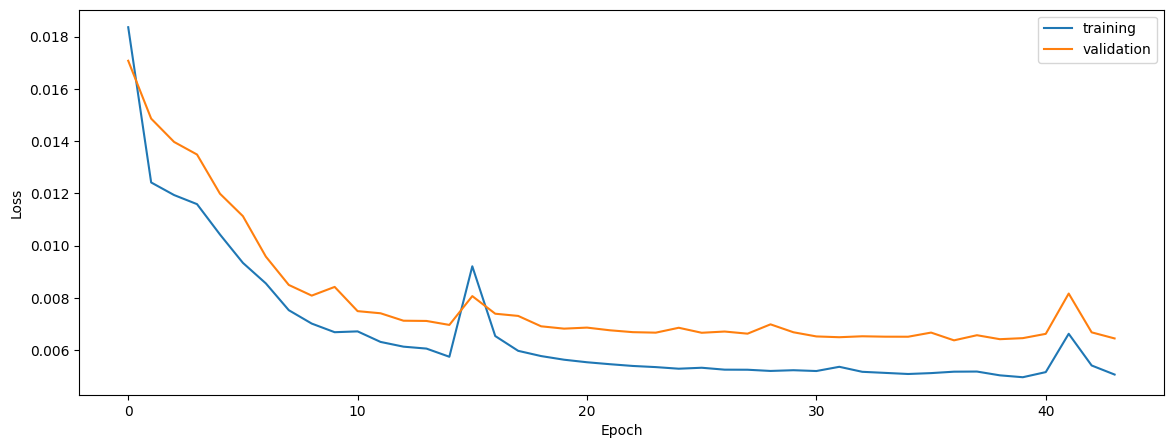

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7665052488210691
0.7393437886275638
0.7317712116061572


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7665052488210691
0.7393437886275638
0.7317712116061572


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7823764953404574
0.7576392724497342
0.7769675845465945


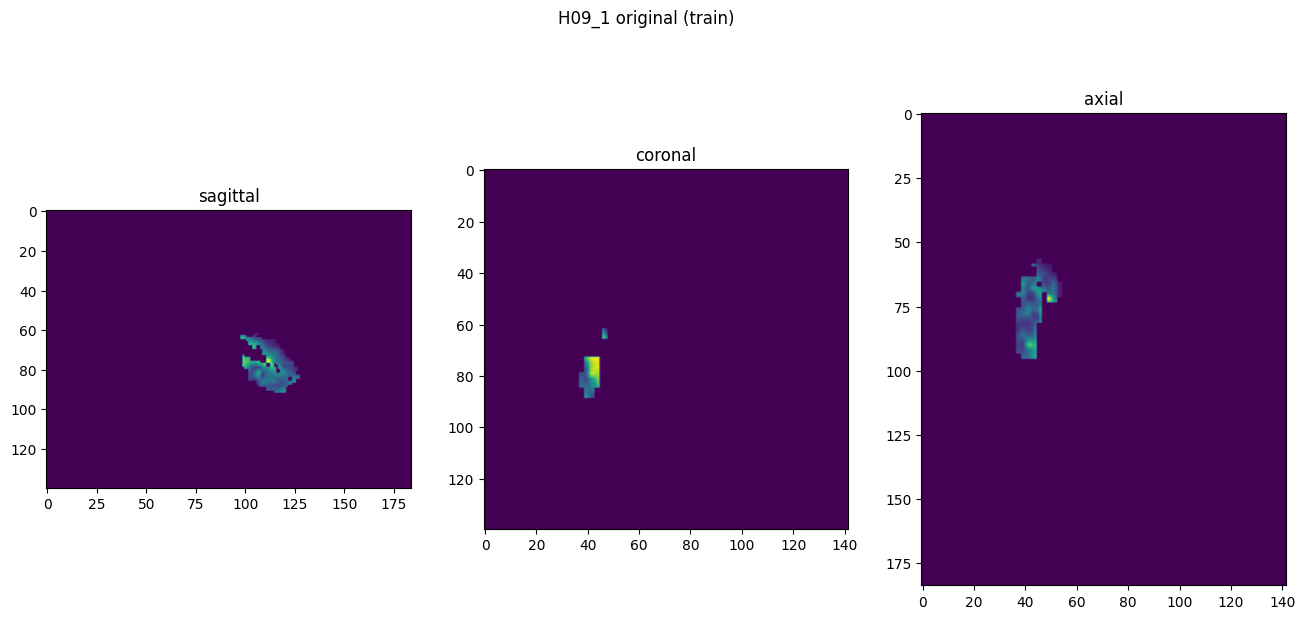

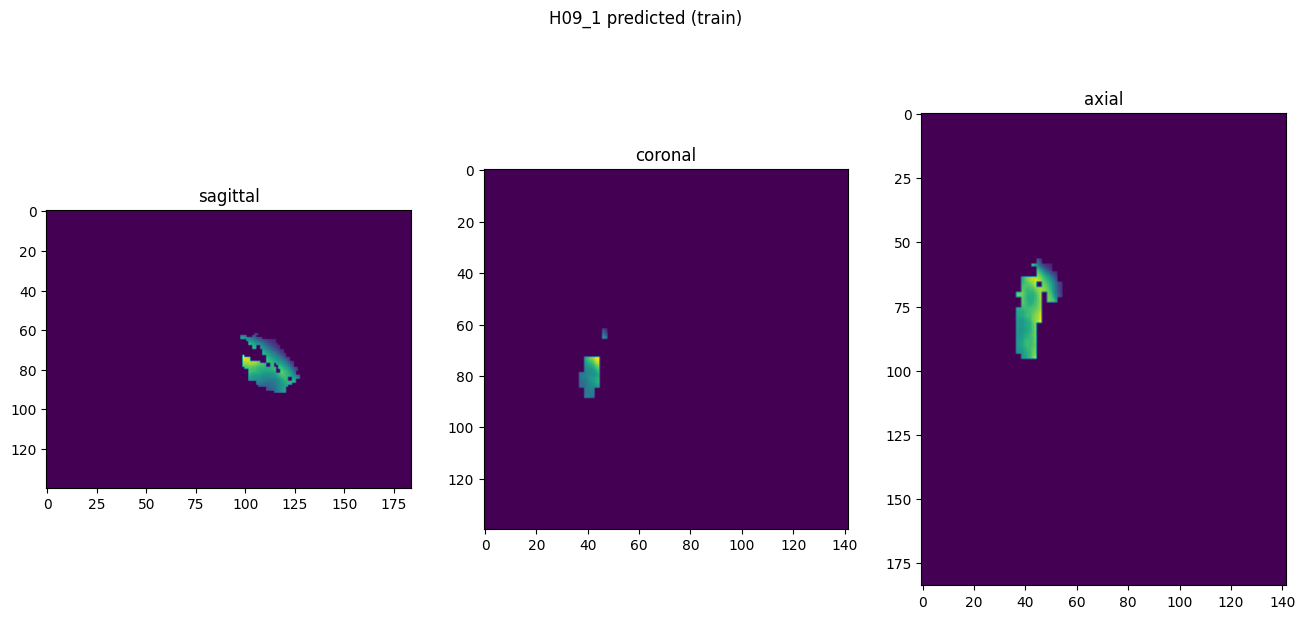

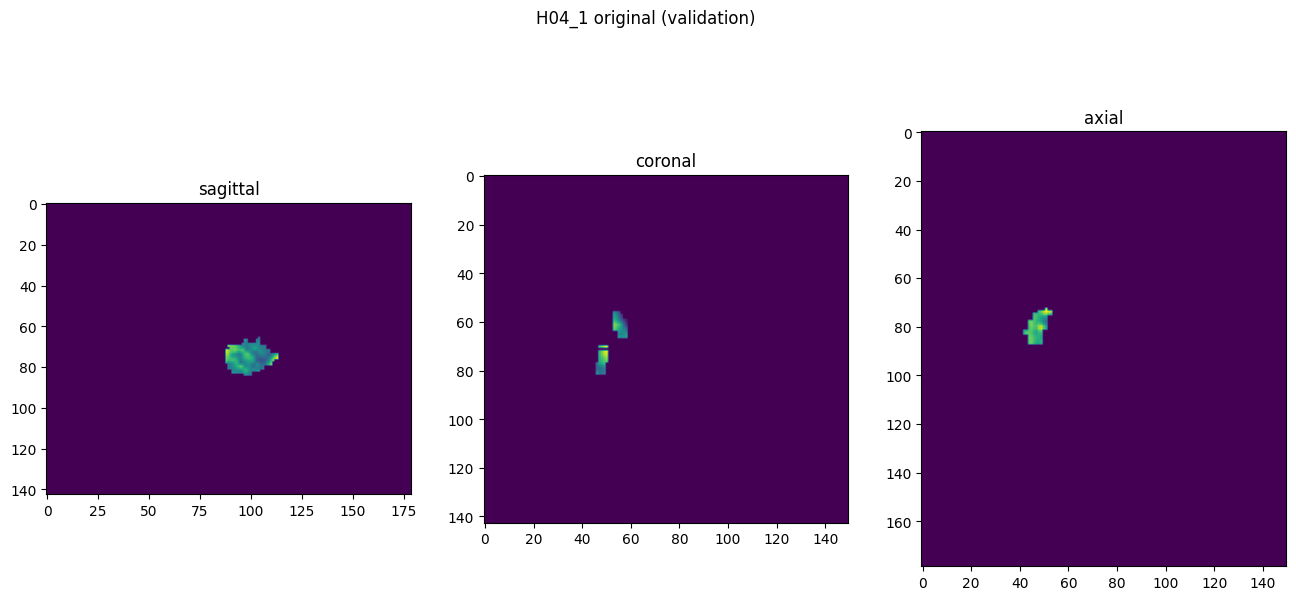

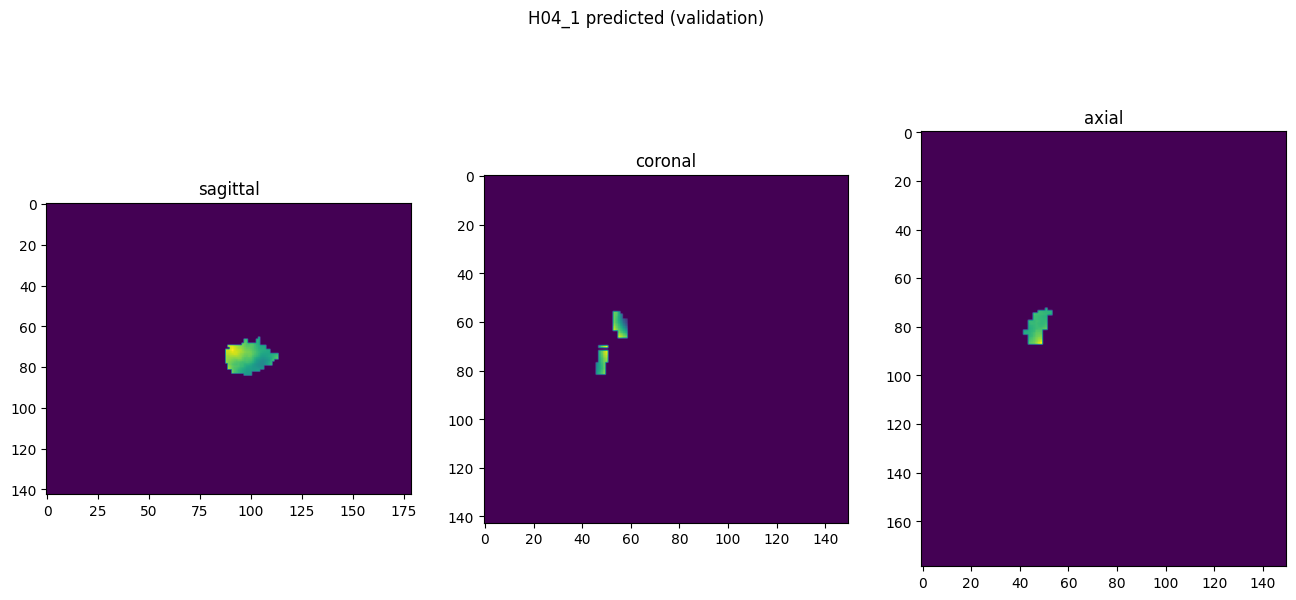

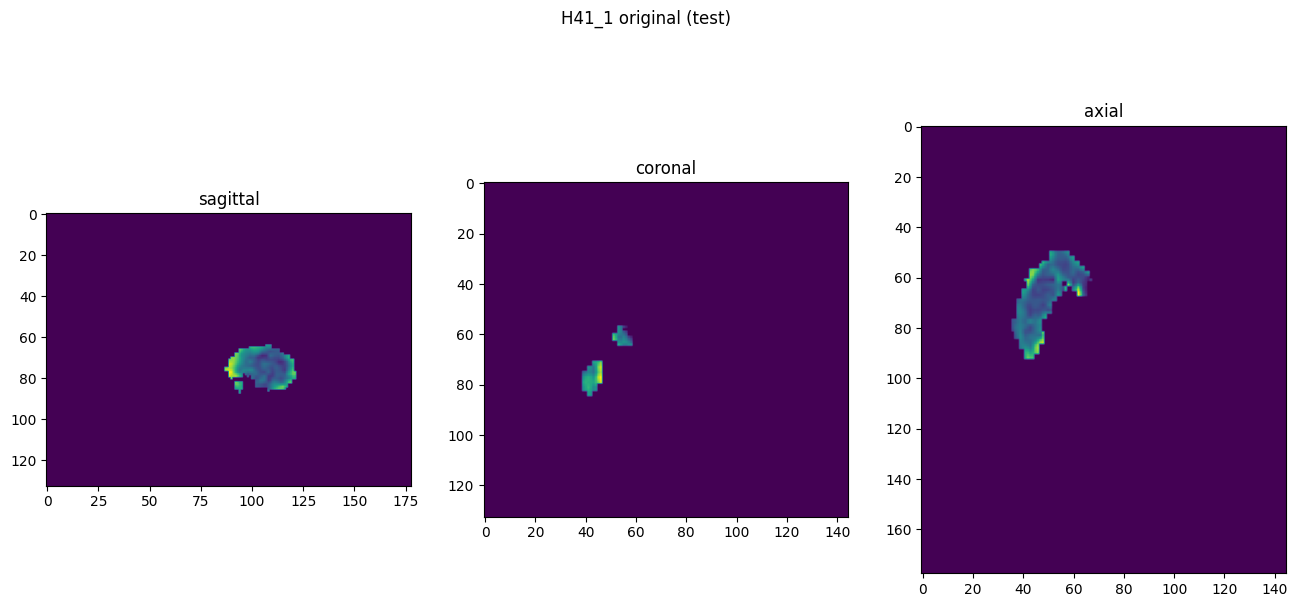

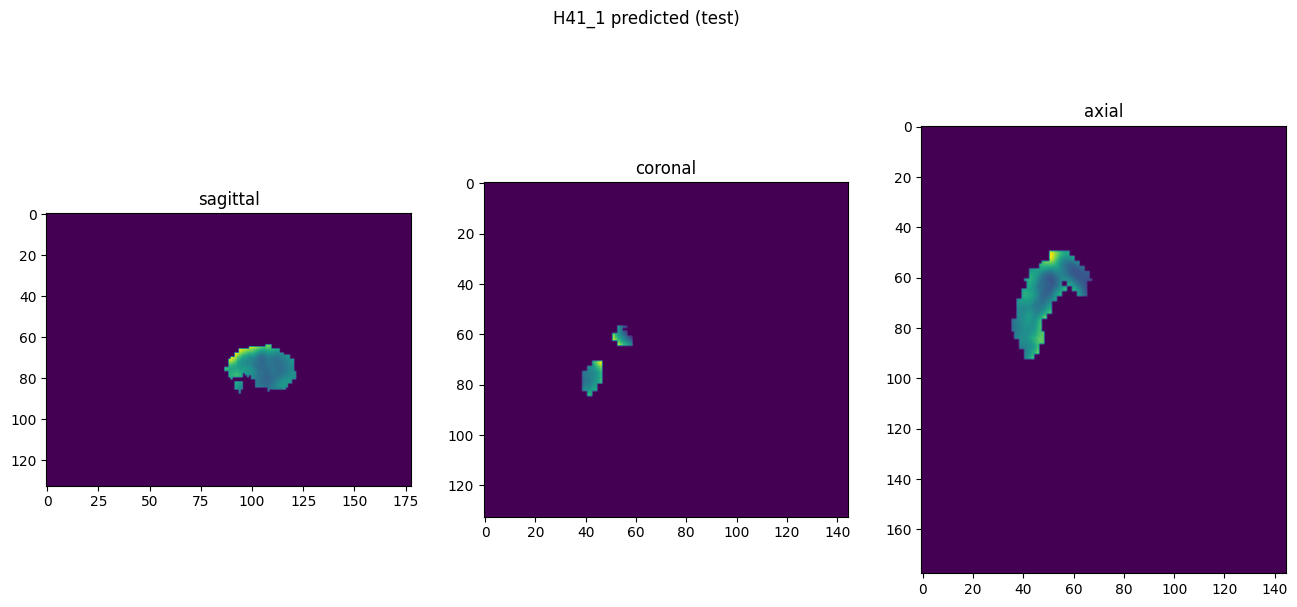

In [10]:
showResults(model, gen, threshold=None, background=False)